In [ ]:

import os
import os.path as op
import errno
from datetime import datetime, timedelta, date
import re
import json
from osgeo import osr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import pandas as pd
import seaborn as sns
import shutil
import argparse
import tempfile
import numpy as np
import glob
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from itertools import cycle
from matplotlib.ticker import MultipleLocator
import zipfile
import xml.etree.ElementTree as ET

In [9]:
def getDateFromStr(N):
    sepList = ["","-","_"]
    YYYYMMDD = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           YYYYMMDD = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return YYYYMMDD

In [10]:
def getDateFromStr(N):
    sepList = ["","-","_"]
    YYYYMMDD = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           YYYYMMDD = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return YYYYMMDD

In [11]:
#grids for 31TCH
tile = "31TCH"
grid_max_K = 44
grid_min_K = 40
grid_max_J = 265
grid_min_J = 262
#tile = "31TGL"
#grid_max_K = 52
#grid_min_K = 49
#grid_max_J = 259
#grid_min_J = 256

In [12]:
spot_names = ["SPOT1","SPOT2","SPOT3"]
ins_names = ["HRV1","HRV2"]

In [13]:
SWH_path = "/datalake/theia/prod/SPOTWORLDHERITAGE"

In [ ]:
#loop throught SPOTWORLDHERITAGE data
dict_ref = {}
for spot_name in spot_names:
    dict_ref[spot_name] = {}
    for ins_name in ins_names:
        dict_ref[spot_name][ins_name] = {}
        dict_ref[spot_name][ins_name]['years'] = {}
        dict_ref[spot_name][ins_name]['months'] = {}
found_scenes   = []     
print("looking for scenes")
all_scenes = glob.glob(op.join(SWH_path,'**','*.zip'), recursive=True)

for scene in all_scenes:
    for K in range(grid_min_K,grid_max_K+1):
        for J in range(grid_min_J,grid_max_J+1):
            if "_0"+str(K)+"-"+str(J) in scene :
                for spot_name in spot_names :
                    if spot_name in scene :
                        for ins_name in ins_names : 
                            if ins_name in scene : 
                                found_scenes.append(scene)
        
nb_scenes_sat_b1 = 0     
nb_scenes_sat_b2 = 0  
nb_scenes_sat_b3 = 0  
nb_scenes = 0

for scene_path in found_scenes:
    #print(scene_path)
    zip_scene = zipfile.ZipFile(scene_path)
    nb_sat_b1 = 0
    nb_sat_b2 = 0
    nb_sat_b3 = 0
    ref_max_XS1 = 0
    ref_min_XS1 = 0
    ref_max_XS2 = 0
    ref_min_XS2 = 0
    ref_max_XS3 = 0
    ref_min_XS3 = 0
    sat_path= ''
    year = 0
    month = 0
    f = ''
    for ziped_file in zip_scene.namelist():
       
        if "SAT_XS.tif" in ziped_file and ".tif.aux.xml" not in ziped_file : sat_path = "/vsizip/"+scene_path+"/"+ziped_file
        if "MTD_ALL.xml" in ziped_file and ".tif.aux.xml" not in ziped_file :
            date_scene = getDateFromStr(ziped_file)
            year = int(date_scene.year)
            month = int(date_scene.month)
            f = zip_scene.read(ziped_file)

    #print(month,year)
    sat = gdal.Open(sat_path)
    array_sat = BandReadAsArray(sat.GetRasterBand(1)).flatten()

    nb_sat_b1 = len(array_sat[np.bitwise_and(array_sat,1) == 1])
    #print("band 1 sat pixels",nb_sat_b1)
    nb_sat_b2 = len(array_sat[np.bitwise_and(array_sat,2) == 2])
    #print("band 2 sat pixels",nb_sat_b2)
    nb_sat_b3 = len(array_sat[np.bitwise_and(array_sat,4) == 4])
    #print("band 3 sat pixels",nb_sat_b3)
    


        

    tree= ET.fromstring(f)

    for t in tree.findall(".//Band_Index_List[@band_id='XS1']/QUALITY_INDEX[@name='ReflectanceMax']"):
        ref_max_XS1 = float(t.text)
    for t in tree.findall(".//Band_Index_List[@band_id='XS1']/QUALITY_INDEX[@name='ReflectanceMin']"):
        ref_min_XS1 = float(t.text)
    for t in tree.findall(".//Band_Index_List[@band_id='XS2']/QUALITY_INDEX[@name='ReflectanceMax']"):
        ref_max_XS2 = float(t.text)
    for t in tree.findall(".//Band_Index_List[@band_id='XS2']/QUALITY_INDEX[@name='ReflectanceMin']"):
        ref_min_XS2 = float(t.text)
    for t in tree.findall(".//Band_Index_List[@band_id='XS3']/QUALITY_INDEX[@name='ReflectanceMax']"):
        ref_max_XS3 = float(t.text)
    for t in tree.findall(".//Band_Index_List[@band_id='XS3']/QUALITY_INDEX[@name='ReflectanceMin']"):
        ref_min_XS3 = float(t.text)
    if ref_max_XS1 == 0 or ref_max_XS2 == 0 or ref_max_XS3 == 0 : 
        print("no max ref !")
        continue
    
    for spot_name in spot_names:
        if spot_name not in ziped_file : continue
        #print(" ",spot_name)
        for ins_name in ins_names:
            if ins_name not in ziped_file : continue
            #print(" "," ",ins_name)
            if year not in dict_ref[spot_name][ins_name]['years']:
                #print(" "," "," ","add year")
                dict_ref[spot_name][ins_name]['years'][year] = {}
                dict_ref[spot_name][ins_name]['years'][year]['XS1'] = {}
                dict_ref[spot_name][ins_name]['years'][year]['XS2'] = {}
                dict_ref[spot_name][ins_name]['years'][year]['XS3'] = {}
                dict_ref[spot_name][ins_name]['years'][year]['XS1']['max'] = []
                dict_ref[spot_name][ins_name]['years'][year]['XS2']['max'] = []
                dict_ref[spot_name][ins_name]['years'][year]['XS3']['max'] = []
                dict_ref[spot_name][ins_name]['years'][year]['XS1']['min'] = []
                dict_ref[spot_name][ins_name]['years'][year]['XS2']['min'] = []
                dict_ref[spot_name][ins_name]['years'][year]['XS3']['min'] = []
                

            if month not in dict_ref[spot_name][ins_name]['months']:
                #print(" "," "," ","add month")
                dict_ref[spot_name][ins_name]['months'][month] = {}
                dict_ref[spot_name][ins_name]['months'][month]['XS1'] = {}
                dict_ref[spot_name][ins_name]['months'][month]['XS2'] = {}
                dict_ref[spot_name][ins_name]['months'][month]['XS3'] = {}
                dict_ref[spot_name][ins_name]['months'][month]['XS1']['max'] = []
                dict_ref[spot_name][ins_name]['months'][month]['XS2']['max'] = []
                dict_ref[spot_name][ins_name]['months'][month]['XS3']['max'] = []
                dict_ref[spot_name][ins_name]['months'][month]['XS1']['min'] = []
                dict_ref[spot_name][ins_name]['months'][month]['XS2']['min'] = []
                dict_ref[spot_name][ins_name]['months'][month]['XS3']['min'] = []

                
            if nb_sat_b1 > 0 : 
                #print(" "," "," ","add X1 ref",ref_max_XS1)
                nb_scenes_sat_b1 = nb_scenes_sat_b1 + 1
                dict_ref[spot_name][ins_name]['years'][year]['XS1']['max'].append(ref_max_XS1)
                dict_ref[spot_name][ins_name]['months'][month]['XS1']['max'].append(ref_max_XS1)
                
            if nb_sat_b2 > 0 : 
                nb_scenes_sat_b2 = nb_scenes_sat_b2 + 1
                dict_ref[spot_name][ins_name]['years'][year]['XS2']['max'].append(ref_max_XS2)
                dict_ref[spot_name][ins_name]['months'][month]['XS2']['max'].append(ref_max_XS2)
            
            if nb_sat_b3 > 0 : 
                nb_scenes_sat_b3 = nb_scenes_sat_b3 + 1
                dict_ref[spot_name][ins_name]['years'][year]['XS3']['max'].append(ref_max_XS3)
                dict_ref[spot_name][ins_name]['months'][month]['XS3']['max'].append(ref_max_XS3)
            nb_scenes = nb_scenes + 1
            
            dict_ref[spot_name][ins_name]['years'][year]['XS1']['min'].append(ref_min_XS1)
            dict_ref[spot_name][ins_name]['years'][year]['XS2']['min'].append(ref_min_XS2)
            dict_ref[spot_name][ins_name]['years'][year]['XS3']['min'].append(ref_min_XS3)
            dict_ref[spot_name][ins_name]['months'][month]['XS1']['min'].append(ref_min_XS1)
            dict_ref[spot_name][ins_name]['months'][month]['XS2']['min'].append(ref_min_XS2)
            dict_ref[spot_name][ins_name]['months'][month]['XS3']['min'].append(ref_min_XS3)
            
            

print(nb_scenes_sat_b1,nb_scenes_sat_b1/nb_scenes*100,nb_scenes_sat_b2,nb_scenes_sat_b2/nb_scenes*100,nb_scenes_sat_b3,nb_scenes_sat_b3/nb_scenes*100,nb_scenes)   
    
    
            
            
            
            
            

In [17]:
with open('data_'+tile+'.json', 'w') as fp:
    json.dump(dict_ref, fp)

In [18]:
with open('data_'+tile+'.json', 'r') as fp:
    dict_ref = json.load(fp)

   Months Instruments     value
0       1  SPOT1_HRV1  0.737127
1       1  SPOT1_HRV2  0.650689
2       1  SPOT2_HRV1  0.646396
3       1  SPOT2_HRV2  0.548878
4       1  SPOT3_HRV1  0.596013
   Months Instruments     value
0       1  SPOT1_HRV1  1.140801
1       1  SPOT1_HRV2  0.936278
2       1  SPOT2_HRV1  0.852338
3       1  SPOT2_HRV2  0.831396
4       1  SPOT3_HRV1  0.715394
   Months Instruments     value
0       1  SPOT1_HRV1  1.326771
1       1  SPOT1_HRV2  1.288479
2       1  SPOT2_HRV1  1.111168
3       1  SPOT2_HRV2  1.022983
4       1  SPOT3_HRV1  1.246126


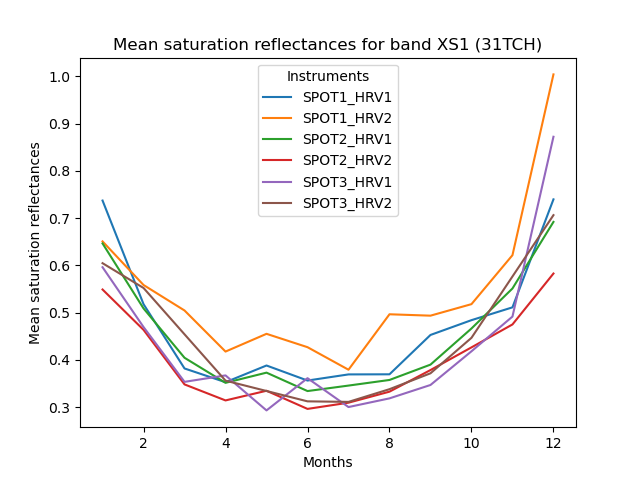

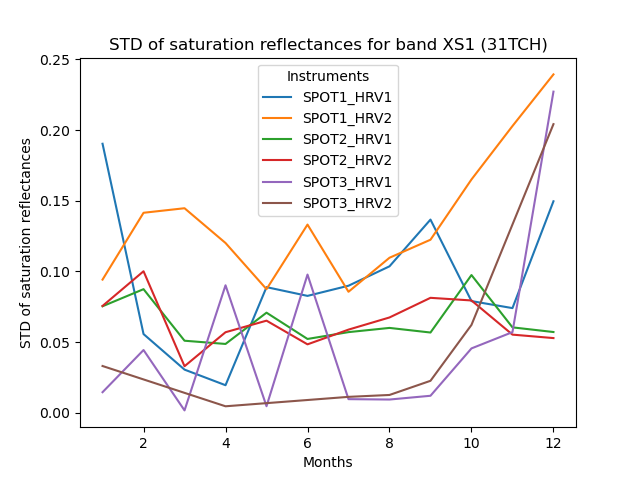

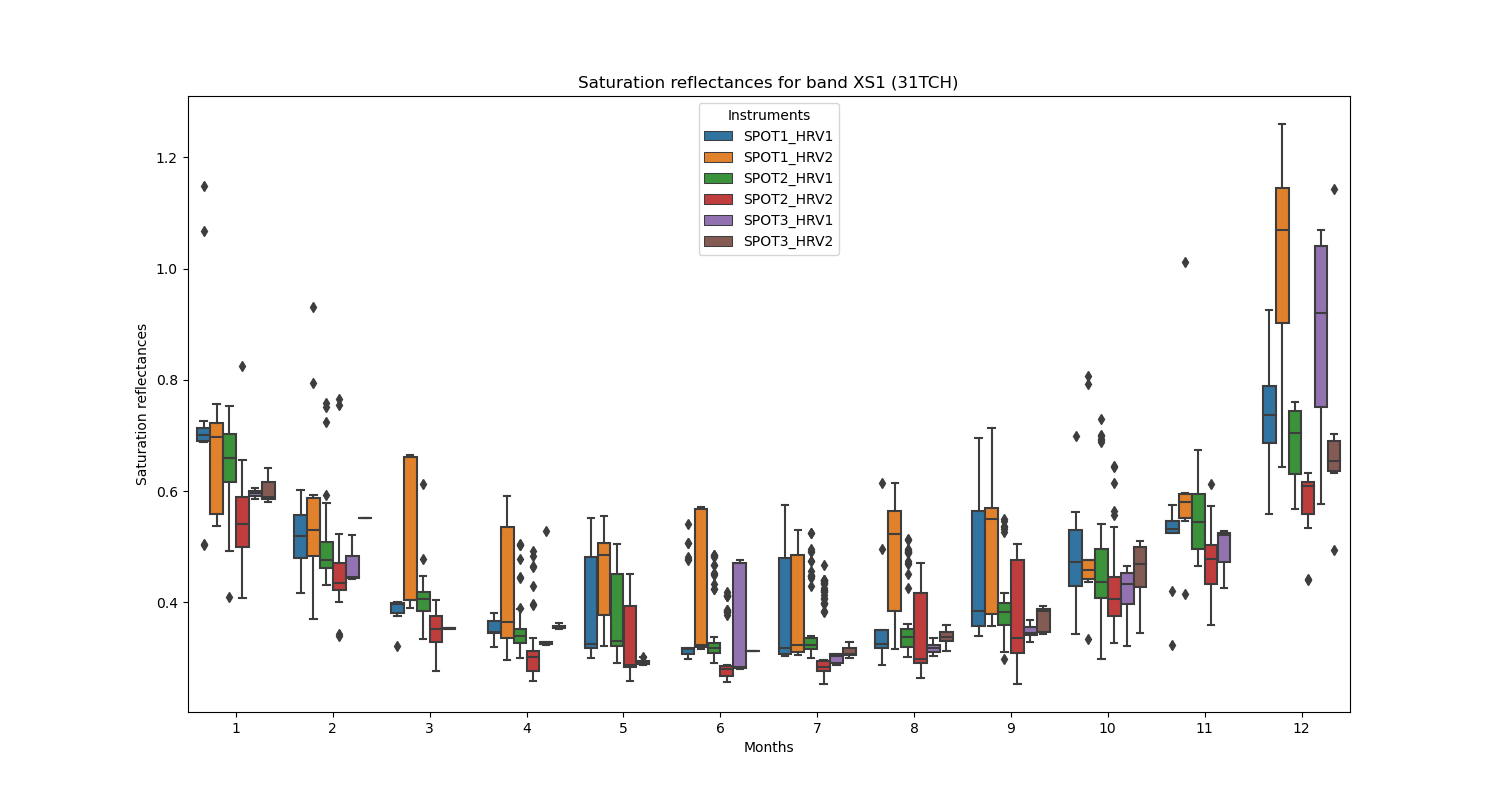

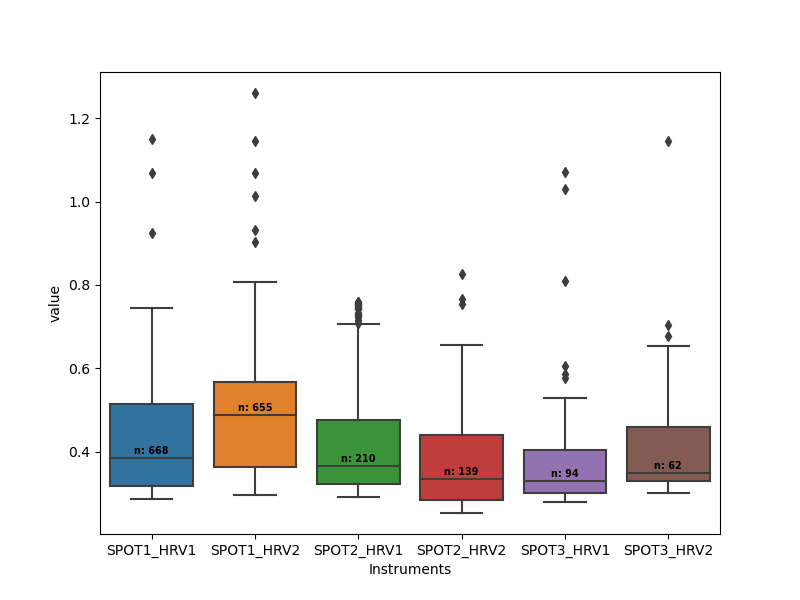

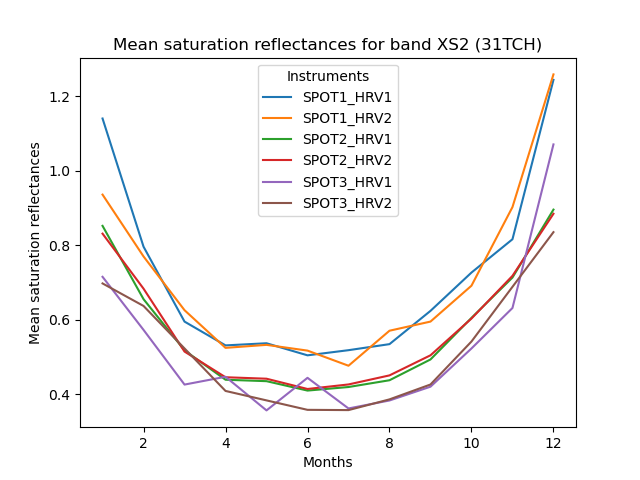

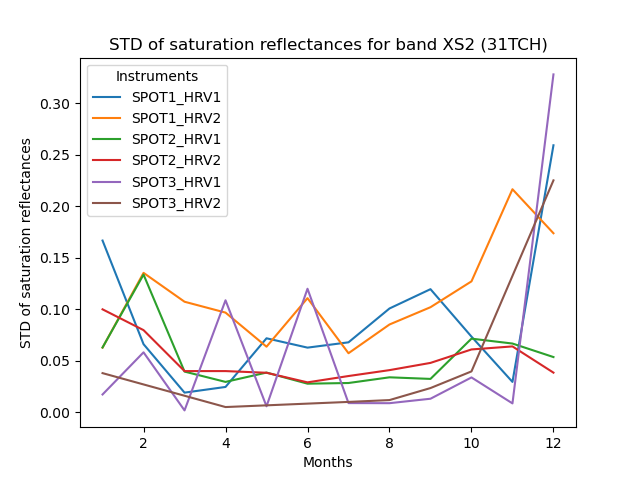

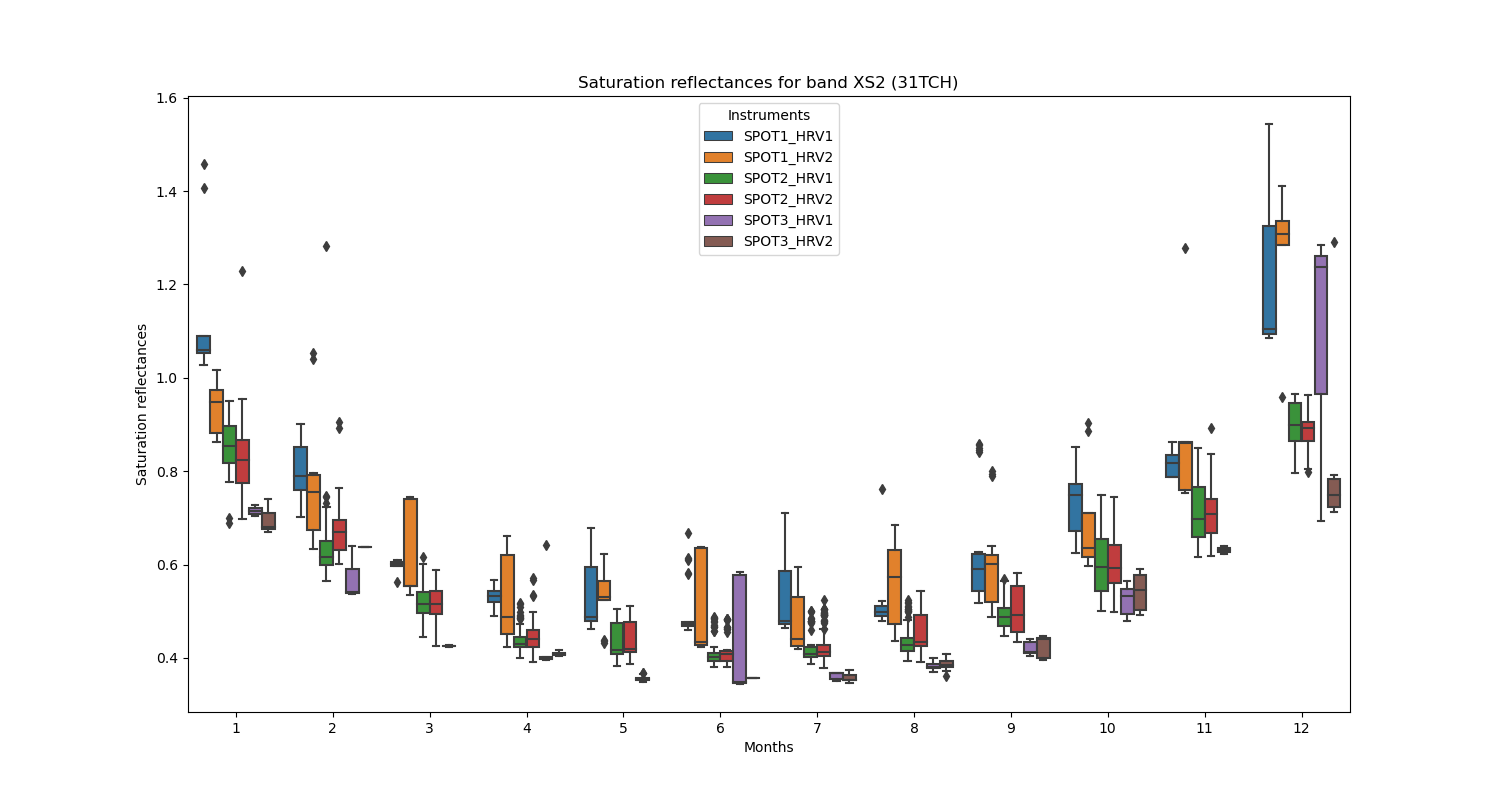

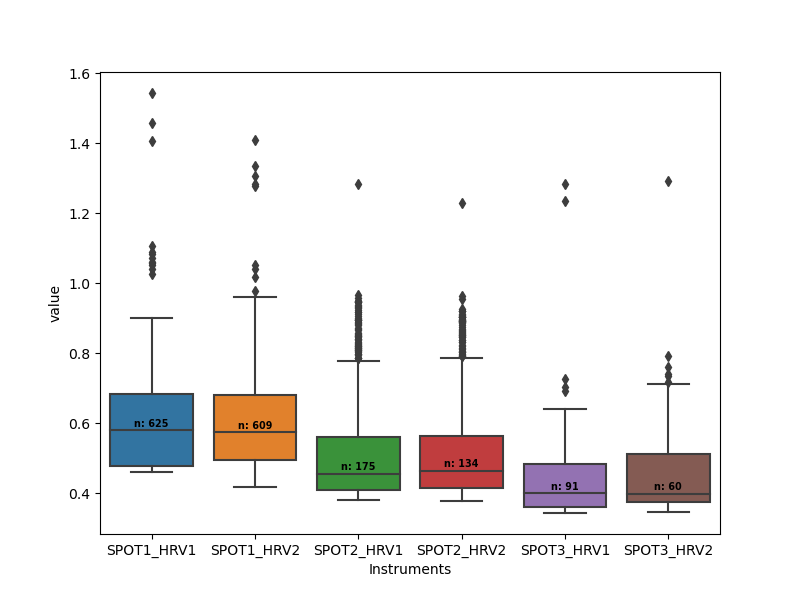

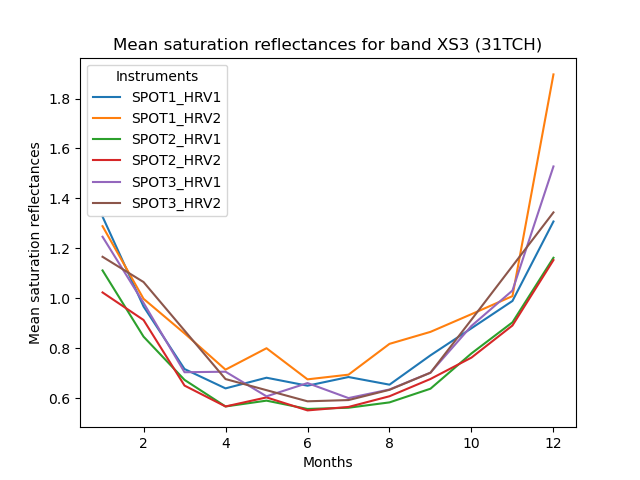

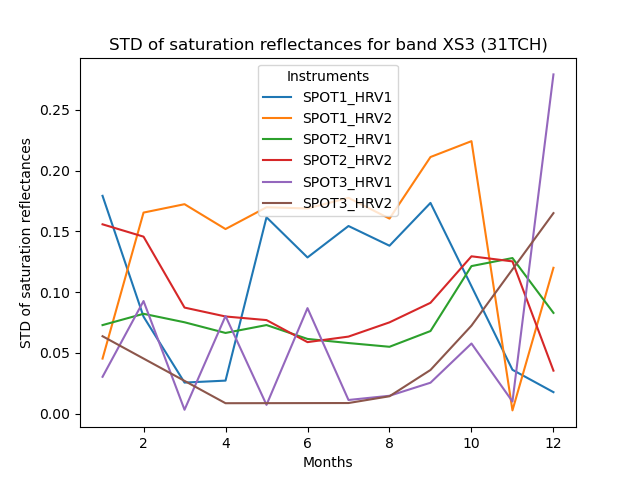

In [19]:


# calculate time series
for band in ['XS1','XS2','XS3']:
    #print(band)

    list_df_ref_max_months = []
    list_df_ref_min_months = []
    t = 1
    for spot_name in sorted(spot_names):
        #print(" ",spot_name)
        for ins_name in sorted(ins_names):
            if len(dict_ref[spot_name][ins_name]['months']) == 0:continue
            #print(" "," ",ins_name)
            list_years = []
            list_months = []
            list_avg_ref_max_years = []
            list_avg_ref_max_months = []
            list_avg_ref_min_years = []
            list_avg_ref_min_months = []
            list_ref_max_months = []
            list_ref_min_months = []
            list_std_ref_max_months = []
            list_std_ref_min_months = []
            #for year in sorted(list(map(int,dict_ref[spot_name][ins_name]['years']))):
                #list_ref_max = dict_ref[spot_name][ins_name]['years'][str(year)][band]['max']
                #list_avg_ref_max_years.append(float(sum(list_ref_max) / len(list_ref_max)))
                #list_ref_min = dict_ref[spot_name][ins_name]['years'][str(year)][band]['min']
                #list_avg_ref_min_years.append(float(sum(list_ref_min) / len(list_ref_min)))
                #list_years.append(year)
            for month in sorted(list(map(int,dict_ref[spot_name][ins_name]['months']))):
                #print(" "," "," ",month)
                list_ref_max = dict_ref[spot_name][ins_name]['months'][str(month)][band]['max']
                
                array_ref_max = np.array(list_ref_max)
                list_ref_max_months.append(list_ref_max)
                list_avg_ref_max_months.append(np.average(array_ref_max))
                list_std_ref_max_months.append(np.std(array_ref_max))
                list_ref_min = dict_ref[spot_name][ins_name]['months'][str(month)][band]['min']
                list_ref_min_months.append(list_ref_min)
                array_ref_min = np.array(list_ref_min)
                list_avg_ref_min_months.append(np.average(array_ref_min))
                list_std_ref_min_months.append(np.std(array_ref_min))
                list_months.append(month)
            #print(" "," ",len(list_months))
            #print(" "," ",len(list_ref_max_months))
                
            df_ref_max_months = pd.DataFrame(list_ref_max_months)
            #print(df_ref_max_months.head(20))
            df_ref_max_months = df_ref_max_months.transpose()
            #print(df_ref_max_months.head(20))
            df_ref_max_months.columns=list_months
            #print(df_ref_max_months.head(20))
            df_ref_max_months = pd.melt(df_ref_max_months,value_vars=list_months,var_name='Months',value_name=spot_name+"_"+ins_name)
            #df_ref_max_months = df_ref_max_months.assign(Instrument=spot_name+"_"+ins_name)
            #print(df_ref_max_months.head(20))
            t = t+1
            #df_ref_min_months = pd.DataFrame(list_ref_min_months, columns=list_months).assign(Trial=spot_name+"_"+ins_name)
            list_df_ref_max_months.append(df_ref_max_months.copy())
            #list_df_ref_min_months.append(df_ref_min_months)
                
    
    
    cdf = pd.concat(list_df_ref_max_months) 
    #print(cdf.head())
    mdf = pd.melt(cdf, id_vars=['Months'], var_name=['Instruments']) 
    #print(mdf.head())
    #print(mdf[mdf['value'].notnull()]['Instruments'].value_counts())
    
    
    #plot average max reflectance lineplot per instruments per months
    avg = mdf.groupby(['Months','Instruments'])['value'].mean().reset_index()
    
    avg.to_csv(tile+"_"+band+"_avg_months"+".csv",sep=';')
    print(avg.head())
    fig = plt.figure()
    ax = sns.lineplot(x='Months', y="value", hue='Instruments', data=avg)  
    ax.set_title("Mean saturation reflectances for band "+band+" ("+tile+")")
    ax.set_ylabel("Mean saturation reflectances")
    #fig.set_size_inches(10, 8)
    #plt.show()
    plt.savefig(tile+"_"+band+"_avg_months"+".png")
    
    #plot std of max reflectance lineplot per instruments per months
    std = mdf.groupby(['Months','Instruments'])['value'].std().reset_index()
    std.to_csv(tile+"_"+band+"_std_months"+".csv",sep=';')
    #print(std.head())
    fig = plt.figure()
    ax = sns.lineplot(x='Months', y="value", hue='Instruments', data=std)  
    ax.set_title("STD of saturation reflectances for band "+band+" ("+tile+")")
    ax.set_ylabel("STD of saturation reflectances")
    #fig.set_size_inches(10, 8)
    #plt.show()
    plt.savefig(tile+"_"+band+"_std_months"+".png")
    
    #plot max reflectances boxplots per instruments per months
    fig = plt.figure()
    ax = sns.boxplot(x='Months', y="value", hue='Instruments', data=mdf)  
    ax.set_title("Saturation reflectances for band "+band +" ("+tile+")")
    ax.set_ylabel("Saturation reflectances")
    fig.set_size_inches(15, 8)
    #plt.show()
    plt.savefig(tile+"_"+band+"_"+"months"+".png")
    
    #plot max reflectances boxplots per instruments
    
    fig = plt.figure()
    ax.set_title("Saturation reflectances for band "+band+" ("+tile+")")
    ax.set_ylabel("Saturation reflectances")
    
    ax = sns.boxplot(x='Instruments', y="value", data=mdf)    
   
           # Calculate number of obs per group & median to position labels
    medians = mdf.groupby(['Instruments'])['value'].median().values
    nobs = mdf[mdf['value'].notnull()]['Instruments'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
           # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
        medians[tick] + 0.01,
        nobs[tick],
        horizontalalignment='center',
        size='x-small',
        color='k',
        weight='semibold')
    #plt.clf()
    
    fig.set_size_inches(8, 6)
    #plt.show()
    plt.savefig(tile+"_"+band+"_.png")
    
    #plt.close(fig)
    
    
    

